# Feature Evaluation and Modeling

This notebook investigates the quality of features from the bicycling and weather data (previously prepared in the data processing notebook) for use in regression models. It will also develop and compare regression models.

In [43]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import pickle
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

In [2]:
with open("../../data/processed/encoded_data.pkl", 'rb') as handle:
    df = pickle.load(handle)

In [6]:
corr = df.corr()

In [7]:
corr.head()

,Fremont Bridge Total,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,cloudCover,...,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12
Fremont Bridge Total,1.000000,0.670992,0.343091,0.556740,-0.176747,0.667913,0.249994,0.537649,-0.180742,-0.475971,...,-0.106443,-0.004371,0.226714,0.216623,0.251883,0.216472,0.095485,-0.022634,-0.169409,-0.298922
apparentTemperatureHigh,0.670992,1.000000,0.413958,0.892981,-0.198179,0.998899,0.304672,0.889967,-0.196379,-0.513019,...,-0.149929,-0.030484,0.159857,0.250846,0.386337,0.391542,0.202486,-0.013185,-0.211051,-0.368686
apparentTemperatureHighTime,0.343091,0.413958,1.000000,0.399290,-0.091204,0.408896,0.671511,0.341417,-0.365065,-0.256258,...,-0.040111,0.039336,0.101080,0.145284,0.188867,0.169366,0.066170,-0.024272,-0.214237,-0.197896
apparentTemperatureLow,0.556740,0.892981,0.399290,1.000000,-0.118714,0.893454,0.304501,0.943692,-0.230098,-0.221920,...,-0.212090,-0.084849,0.122903,0.236651,0.347103,0.384521,0.247322,0.059887,-0.164509,-0.341897
apparentTemperatureLowTime,-0.176747,-0.198179,-0.091204,-0.118714,1.000000,-0.190962,-0.035337,-0.162995,0.054454,0.150097,...,0.016314,-0.045146,-0.082167,-0.094208,-0.083999,-0.037913,-0.041082,0.043907,0.079501,0.090202


In [24]:
high_corr = []
for column in corr.columns:
    for ind, val in enumerate(corr[column]):
        if np.abs(val) > 0.75 and np.abs(val) < 1:
            high_corr.append([ind, column])

In [25]:
rows = {}
for x in list(range(0, len(corr.columns))):
    rows[x] = corr.columns[x]

In [26]:
for each in high_corr:
    each[0] = rows[each[0]]

In [30]:
high_corr

[['apparentTemperatureLow', 'apparentTemperatureHigh'],
 ['apparentTemperatureMax', 'apparentTemperatureHigh'],
 ['apparentTemperatureMin', 'apparentTemperatureHigh'],
 ['dewPoint', 'apparentTemperatureHigh'],
 ['sunsetTime', 'apparentTemperatureHigh'],
 ['temperatureHigh', 'apparentTemperatureHigh'],
 ['temperatureLow', 'apparentTemperatureHigh'],
 ['temperatureMax', 'apparentTemperatureHigh'],
 ['temperatureMin', 'apparentTemperatureHigh'],
 ['uvIndex', 'apparentTemperatureHigh'],
 ['temperatureHighTime', 'apparentTemperatureHighTime'],
 ['apparentTemperatureHigh', 'apparentTemperatureLow'],
 ['apparentTemperatureMax', 'apparentTemperatureLow'],
 ['apparentTemperatureMin', 'apparentTemperatureLow'],
 ['dewPoint', 'apparentTemperatureLow'],
 ['temperatureHigh', 'apparentTemperatureLow'],
 ['temperatureLow', 'apparentTemperatureLow'],
 ['temperatureMax', 'apparentTemperatureLow'],
 ['temperatureMin', 'apparentTemperatureLow'],
 ['apparentTemperatureHigh', 'apparentTemperatureMax'],
 ['

Let's drop the "apparent" temperature columns and the temperature min/max columns (which seem to be almost the same as the temperature high/low columns).

In [32]:
for x in df.columns:
    if x.startswith("apparent"):
        df.drop(x, axis = 1, inplace = True)

In [35]:
df.drop(['temperatureMin', 'temperatureMax', 'temperatureMinTime', 'temperatureMaxTime'], axis = 1, inplace = True)

In [38]:
df.drop(['DayOfWeek', 'Month', 'precipType'], axis = 1, inplace = True)

In [33]:
df.columns

Index(['Date', 'Fremont Bridge Total', 'cloudCover', 'dewPoint', 'humidity',
       'moonPhase', 'precipIntensity', 'precipIntensityMax',
       'precipProbability', 'precipType', 'pressure', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'temperatureHighTime',
       'temperatureLow', 'temperatureLowTime', 'temperatureMax',
       'temperatureMaxTime', 'temperatureMin', 'temperatureMinTime', 'uvIndex',
       'uvIndexTime', 'visibility', 'windBearing', 'windGust', 'windGustTime',
       'windSpeed', 'snowAccumulation', 'DayOfWeek', 'Month', 'rain', 'snow',
       'DoW1', 'DoW2', 'DoW3', 'DoW4', 'DoW5', 'DoW6', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12'],
      dtype='object')

In [41]:
corr_edit = df.corr()

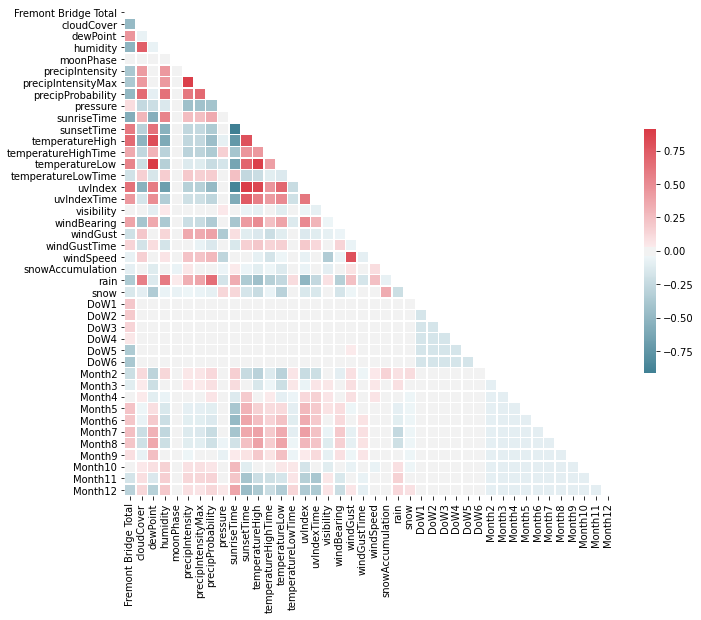

In [47]:
mask = np.triu(np.ones_like(corr_edit, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_edit, 
            mask=mask, 
            cmap=cmap, 
            #vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})